# Tutorial: Building a Browser Use Agent From Scratch and with Magentic-UI - Level 2



You might have seen cool video demos online of AI agents taking control of a computer or a browser to perform tasks. This is a new category of agents referred to as Computer-Use-Agents (CUA) or Browser-Use-Agents (BUA). Examples of such CUA/BUA agents include [OpenAI's Operator](https://openai.com/index/introducing-operator/), [Claude Computer Use Model](https://docs.anthropic.com/en/docs/agents-and-tools/tool-use/computer-use-tool), [AutoGen's MultiModalWebSurfer](https://microsoft.github.io/autogen/stable/reference/python/autogen_ext.agents.web_surfer.html), [Adept AI](https://www.adept.ai/blog/act-1), [Google's Project Mariner](https://deepmind.google/models/project-mariner/) and [Browser-Use](https://github.com/browser-use/browser-use/tree/main) among many others.


## What is a Computer Use Agent?

**Definition**: A computer or browser use agent is an agent that given a task, e.g., "order a shawarma sandwich from BestShawarma for pickup now", can programmatically control a computer or browser to autonomously complete the task. By "control a browser" we mean interacting with the browser in a similar way to how a human might control the browser: clicking on buttons, typing in fields, scrolling and so on. Note that a tool-use language model agent could complete this food ordering task if it had access to the restaurant API for instance, this would not make it a CUA agent as it is not _interacting_ with the browser to complete the task.

To make this distinction more clear, here is another example task.
Suppose we wanted to find the list of available Airbnbs in Miami from 6/18 to 6/20 for 2 guests.

![airbnb_sc.png](airbnb_sc.png)

How would a browser use agent solve this task:

- **Step 1:** Visit airbnb.com
- **Step 2:** Type "Miami" in the "Where" input box
- **Step 3:** Select "6/18" in the "Check in" date box
- **Step 4:** Select "6/20" in the "Check out" date box
- **Step 5:** Click on the "Who" button
- **Step 6:** Click "+" twice to add two guests
- **Step 7:** Click "Search" button
- **Step 8:** Summarize and extract listings from the webpage

On the other hand, suppose we had an API for Airbnb that looks like: `find_listings(location, check_in, check_out, guests)`

Then a tool-call agent would first need to generate a tool call: `find_listings("Miami", 6/18, 6/20, 2)` and read out the result of the tool call.

Clearly if we had an API for every website and everything on the computer, then it would be much simpler to perform this task. _But that is not the case currently_, many interfaces on the web cannot be accessed by an API and so the only way is through interacting with the website directly. While future interfaces might become more directly accessible to agents via APIs and MCP servers, for now we need to perform direct manipulation with the websites.

## What Does This Tutorial Cover?

In this tutorial, we will cover how to build a basic browser-use agent. The goal of this tutorial is to demystify such agents and show how we can build a simple version of them. The only thing we need is access to a large language model (LLM) that can perform tool calling or structured JSON outputs (GPT-4o, Qwen2.5-VL, Llama 3.1, ...). The LLM does not need to be vision capable, but a model capable of taking image input would improve performance significantly. The LLM also does not need to be trained previously for browser-use, out of the box LLMs can be turned into semi-capable browser-use agents following the recipe in this tutorial. At the end of the tutorial we will discuss further directions.

We will cover three levels of building your browser use agent:

- Level 1: From scratch using only the `playwright` python package.
- Level 2: Using helpers from the `magentic-ui` package which simplifies building your agent.
- Level 3: Using the WebSurfer Agent from the `magentic-ui` package directly.

This is Level 2.

# Tutorial Prerequisites




You will need Python >3.10 to run this tutorial and the `magentic-ui` package. [Magentic-UI](https://github.com/microsoft/magentic-ui/tree/main) is a research prototype from Microsoft of a human-centered agentic interface. In this tutorial we will be using utilities and helpers from that package without using the Magentic-UI application itself.

We recommend using a virtual environment to avoid conflicts with other packages.

```bash
python3 -m venv .venv
source .venv/bin/activate
pip install magentic-ui
```

Alternatively, if you use [`uv`](https://docs.astral.sh/uv/getting-started/installation/) for dependency management, you can install Magentic-UI with:

```bash
uv venv --python=3.12 .venv
. .venv/bin/activate
uv pip install magentic-ui
```

We also need to install the browsers that our agent will control with playwright:

```bash
playwright install --with-deps chromium
```

The other thing you need to set up is your LLM. The easiest way to follow this tutorial is to obtain an OpenAI API key and set it as an environment variable:

```bash
export OPENAI_API_KEY=<YOUR API KEY>
```

You can also use any open source model with [Ollama](https://ollama.com/) if you have a capable GPU at your disposal. We will be covering both using OpenAI and Ollama.

# Level 2: Building a Browser Use Agent Using Magentic-UI

While it was fun building the browser use agent from scratch, it was not easy. We had to figure out how to launch the browser, fiddle around with playwright to extract interactive elements, figure out how to execute actions on the page and so on.

The `magentic-ui` library as we will see has many utilities that will make your life much easier when building browser use agents. We will now do the same steps as before but by using the helpers from the `magentic-ui` library.


## Step 1: Launching a Browser

Magentic-UI provides three different Playwright browser implementations, each designed for specific use cases:

1. Local Playwright Browser (`LocalPlaywrightBrowser`)
- **Purpose**: Runs Playwright directly on the local machine without Docker
- **Use Case**: Development and testing environments where Docker isn't needed
- **Features**: Lightweight, direct browser control, supports both headless and headed modes

2. Headless Docker Playwright Browser (`HeadlessDockerPlaywrightBrowser`)  
- **Purpose**: Runs a headless Playwright browser inside a Docker container
- **Use Case**: Production environments, CI/CD pipelines, server-side automation
- **Features**: Isolated execution, reproducible environment, no GUI overhead and more secure.
- **Docker Image**: Uses Microsoft's official Playwright Docker image (`mcr.microsoft.com/playwright:v1.51.1-noble`)

3. VNC Docker Playwright Browser (`VncDockerPlaywrightBrowser`)
- **Purpose**: Runs Playwright in Docker with VNC support for visual interaction, you can interact with the browser on localhost.
- **Use Case**: Debugging, development, and scenarios requiring visual browser inspection
- **Features**: Programmatic control + visual access via noVNC web interface
- **Docker Image**: Uses custom `magentic-ui-vnc-browser` image with VNC server. You need to run `magentic-ui --rebuild-docker` command to build it.

How to Launch Each Browser:

```python
from pathlib import Path
from magentic_ui.tools.playwright import HeadlessDockerPlaywrightBrowser, VncDockerPlaywrightBrowser, LocalPlaywrightBrowser

# Direct instantiation examples
async def launch_browsers():
    # Headless Docker Browser
    headless_browser = HeadlessDockerPlaywrightBrowser(
        playwright_port=37367,
        inside_docker=False
    )
    
    # VNC Docker Browser  
    vnc_browser = VncDockerPlaywrightBrowser(
        bind_dir=Path("./workspace"),
        playwright_port=37367,
        novnc_port=6080,
        inside_docker=False
    )
    
    # Local Browser
    local_browser = LocalPlaywrightBrowser(headless=True)
    
```



For simplicity we will stick with the local playwright browser that we launched in Level 1:

In [ ]:
from magentic_ui.tools.playwright import LocalPlaywrightBrowser
browser = LocalPlaywrightBrowser(headless=False)
# Start the browser
await browser._start()
# Get the browser context and start a new page
context = browser.browser_context
page = await context.new_page()


You should now see a browser open to the blank page.

## Step 2: Represent the browser for the Agent using Set-Of-Marks Prompting.

To get the interactive elements on the page, we have done a lot of work for you in Magentic-UI to capture every posible interactive element type on the page including elements in the shadow-DOM [(see this javascript file if interested for more info)](https://github.com/microsoft/magentic-ui/blob/main/src/magentic_ui/tools/playwright/page_script.js).

These utilities are wrapped in a helper class called the [`PlaywrightController`](https://github.com/microsoft/magentic-ui/blob/main/src/magentic_ui/tools/playwright/playwright_controller.py)

In [31]:
from magentic_ui.tools.playwright import PlaywrightController
browser_controller = PlaywrightController(viewport_width=1280, viewport_height=720)

The PlaywrightController has a lot of convenience methods that have been debugged extensively so that we can perform actions on the browser more reliably and securily.

There are methods to get the interactive elements, get the screenshot, click, type, scroll, manage tabs, hover, describe pages in markdown and much more.

For now, let's navigate to Bing using our `browser_controller`.

In [33]:
_ = await browser_controller.visit_page(page, "https://www.bing.com")

The visit_page method only returns when the page is fully loaded.

Now let us get the set of interactive elements:

In [37]:
interactive_elements = await browser_controller.get_interactive_rects(page)
# print the first 20 interactive elements
i = 0
for element in interactive_elements:
    print(f"Element {i}: id={element}, data={interactive_elements[element]}")
    i += 1
    if i > 20:
        break

Element 0: id=10, data={'tag_name': 'svg', 'role': 'img', 'aria_name': 'Microsoft Logo Image', 'v_scrollable': False, 'rects': [{'x': 11.680000305175781, 'y': 20.079999923706055, 'width': 178.6400146484375, 'height': 27.839998245239258, 'top': 20.079999923706055, 'right': 190.32001495361328, 'bottom': 47.91999816894531, 'left': 11.680000305175781}]}
Element 1: id=11, data={'tag_name': 'a', 'role': 'link', 'aria_name': 'Copilot', 'v_scrollable': False, 'rects': [{'x': 250, 'y': 14, 'width': 64.46875, 'height': 39, 'top': 14, 'right': 314.46875, 'bottom': 53, 'left': 250}]}
Element 2: id=12, data={'tag_name': 'a', 'role': 'link', 'aria_name': 'Images', 'v_scrollable': False, 'rects': [{'x': 350.46875, 'y': 26, 'width': 42.640625, 'height': 15, 'top': 26, 'right': 393.109375, 'bottom': 41, 'left': 350.46875}]}
Element 3: id=13, data={'tag_name': 'a', 'role': 'link', 'aria_name': 'Videos', 'v_scrollable': False, 'rects': [{'x': 429.109375, 'y': 26, 'width': 39.515625, 'height': 15, 'top': 

You'll notice that this ran much faster than using the Playwright script in Level 1 tutorial because here we are using javascript to extract the elements instead of going through the playwright API.

Our searchbox is now Element id 22 and has the following data:


    Element 12: id=22, data={'tag_name': 'textarea', 'role': 'textbox', 'aria_name': '0 characters out of 2000', 'v_scrollable': False, 'rects': [{'x': 193, 'y': 158, 'width': 843, 'height': 22, 'top': 158, 'right': 1036, 'bottom': 180, 'left': 193}]}

To type in the searchbox we can use the fill_id method of the PlaywrightController:

In [38]:

await browser_controller.fill_id(page, "22", "Magentic-UI")


Let's check if we are the right page:

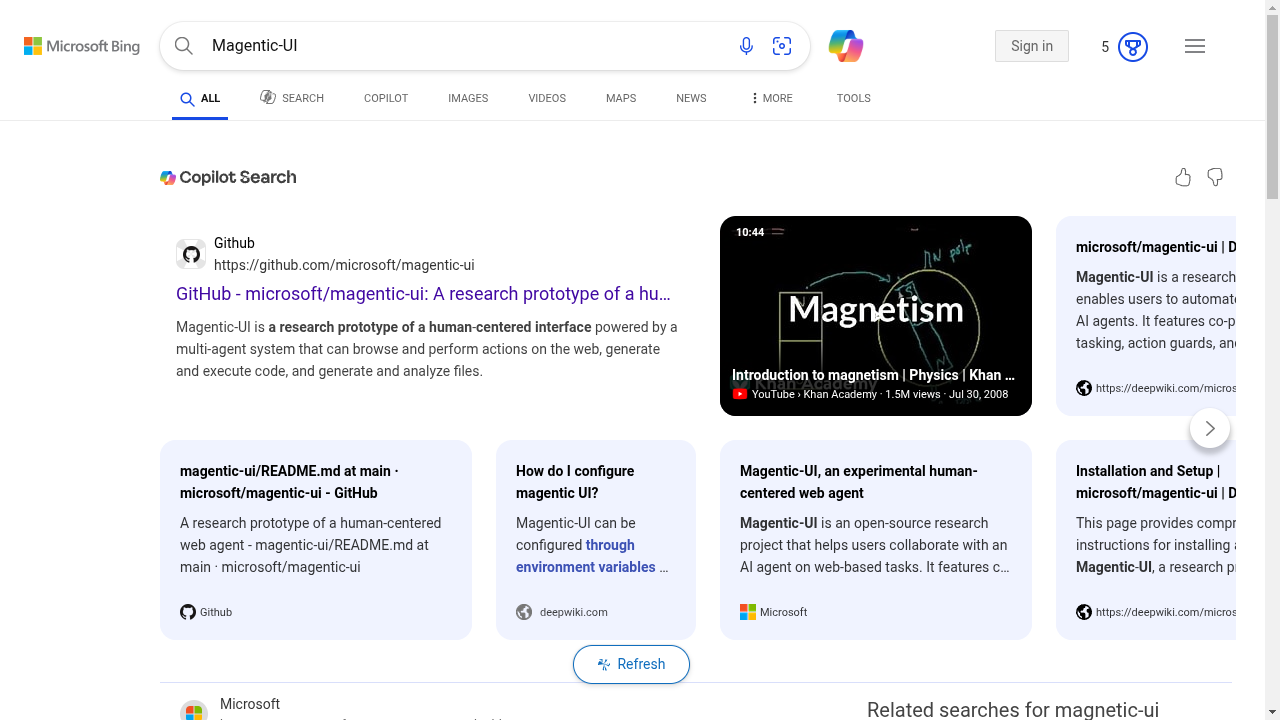

In [43]:
from PIL import Image
import io
from IPython.display import display

screenshot = await browser_controller.get_screenshot(page)
image = Image.open(io.BytesIO(screenshot))
display(image)


We can also easily extract the search results using the get_page_markdown method that uses the [`markitdown`](https://github.com/microsoft/markitdown) package from our team at Microsoft Research.

In [44]:
page_text = await browser_controller.get_page_markdown(page)
print(page_text)

## A Bing search for 'Magentic-UI' found the following results:

1. [![Global web icon](https://th.bing.com/th/id/ODLS.33c6a76b-616a-4fc5-ac11-7a644a97dc30?w=32&h=32&qlt=91&pcl=fffffa&o=6&pid=1.2)
Microsoft
https://www.microsoft.com › en-us › research › blog › ...](https://www.microsoft.com/en-us/research/blog/magentic-ui-an-experimental-human-centered-web-agent/?msockid=2dd5c120708162751f88d72d71a763f0)
## [Magentic-UI, an experimental human-centered web agent](https://www.microsoft.com/en-us/research/blog/magentic-ui-an-experimental-human-centered-web-agent/?msockid=2dd5c120708162751f88d72d71a763f0)
May 19, 2025 · Magentic-UI is an open-source research project that helps users collaborate with an AI agent on web-based tasks. It features co-planning, co-tasking, action guards, and plan …

2. [![Global web icon](https://th.bing.com/th/id/ODLS.A2450BEC-5595-40BA-9F13-D9EC6AB74B9F?w=32&h=32&qlt=92&pcl=fffffa&o=6&pid=1.2)
deepwiki.com
https://deepwiki.com › microsoft › magentic-ui](https:

The final thing we need is to get the set-of-marks image:

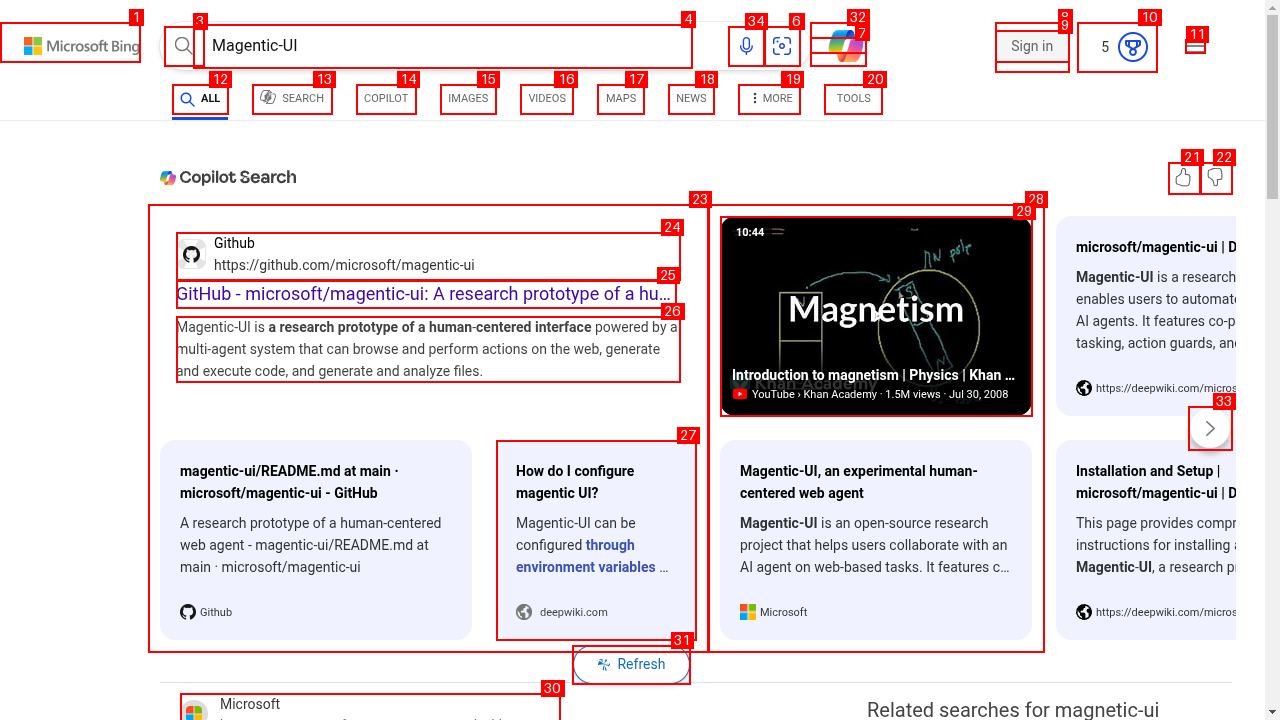

In [48]:
from magentic_ui.agents.web_surfer._set_of_mark import add_set_of_mark


interactive_elements = await browser_controller.get_interactive_rects(page)
screenshot = await browser_controller.get_screenshot(page)
som_screenshot, visible_elements, elements_above, elements_below, _ = add_set_of_mark(
    screenshot, interactive_elements, use_sequential_ids=True
)

display(som_screenshot)


The add_set_of_mark method returns the SoM screenshot in addition to elements visible on the viewport, elements above the viewport and elements below the viewport.

We can see how much the `magentic-ui` makes our life easier with these tools, we are now ready to re-implement the agent from Level 1!

## Step 3: Putting it all together

Using the tools from the `magentic-ui` library now we can more easily implement our BrowserUseAgent:

In [71]:
from openai import OpenAI
from playwright.async_api import Page
from playwright.async_api import async_playwright
from PIL import Image, ImageDraw
import io
import base64
import json
from dataclasses import dataclass
from IPython.display import display
from magentic_ui.tools.playwright import LocalPlaywrightBrowser
from magentic_ui.tools.playwright import PlaywrightController
from magentic_ui.agents.web_surfer._set_of_mark import add_set_of_mark


AGENT_PROMPT = """
You are a helpful assistant that can navigate a web page and perform actions on it.

The task we are trying to complete is:
{task}

The current visible text on the page is:
{page_text}

The current visible elements on the page are:
{formatted_list_of_elements}

You will need to decide on the next action to take.

The action space is:
- goto(url): navigate to a URL
- click(id): click a button given it's ID
- type(id, text): type "text" into element "id"
- scroll(direction): scroll the page in direction up or down.
- stop_action(final_answer): declare that we have finished the task and prepare a final_answer to return to the user.

Output a JSON object with the following fields:
{{
    "action": "goto" | "click" | "type" | "scroll" | "stop_action",
    "action_args": {{
        "url": "https://www.google.com",
        "id": "123",
        "text": "Hello",
        "direction": "up"
    }}
}}

Only output the JSON object, no other text or comments.
"""


class BrowserUseAgent:
    def __init__(
        self,
        client: OpenAI,
        model: str = "gpt-4o",
        headless: bool = False,
        run_in_jupyter: bool = True,
    ):
        self.client = client
        self.model = model
        self.headless = headless
        self.message_history: list[dict] = []
        self.page: Page = None
        self.run_in_jupyter = run_in_jupyter
        self.browser_controller = PlaywrightController(
            viewport_width=1280, viewport_height=720
        )

    async def _launch_browser(self) -> None:
        self.browser = LocalPlaywrightBrowser(headless=False)
        # Start the browser
        await self.browser._start()
        # Get the browser context and start a new page
        self.context = self.browser.browser_context
        self.page = await self.context.new_page()

    async def execute_task(self, task: str) -> str:
        """
        This is NEW! This is the main function that will be called to execute the task and implement our agent loop.
        """
        # Step 1: Launch the browser if it's not already launched
        if self.page is None:
            await self._launch_browser()
        # Our stop condition is when the LLM decides to output stop_action
        should_stop = False
        final_answer = None
        i = 0
        while not should_stop:
            # Step 2: Prepare the page for the agent
            (
                page_text,
                formatted_list_of_elements,
                som_screenshot,
            ) = await self._prepare_page_for_agent(self.page)
            # Step 3: Get the LLM response
            image_data_url = f"data:image/png;base64,{base64.b64encode((lambda b: (som_screenshot.save(b, format='PNG'), b.getvalue())[1])(io.BytesIO())).decode()}"
            action_decision = self._get_llm_response(
                self.client,
                task,
                page_text,
                formatted_list_of_elements,
                image_data_url,
                self.message_history,
                self.model,
            )
            print(f"Action decision {i}: {action_decision}")
            # Add the action decision to the message history
            self.message_history.append(
                {
                    "role": "user",
                    "content": [{"type": "text", "text": json.dumps(action_decision)}],
                }
            )
            # Step 4: Execute the action with some error handling
            try:
                action_feedback = await self._execute_action(
                    action_decision["action"], action_decision["action_args"], self.page
                )
            except Exception as e:
                print(f"Error executing action {i}: {e}")
                action_feedback = f"Error executing action {i}: {e}"
            print(f"Action feedback {i}: {action_feedback}")
            # Sleep for 3 seconds to let the page load
            await self.page.wait_for_timeout(3000)
            # Update the message history with feedback on the action and the new page screenshot
            new_page_screenshot = await self.page.screenshot()
            self.message_history.append(
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": action_feedback},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/png;base64,{base64.b64encode(new_page_screenshot).decode()}"
                            },
                        },
                    ],
                }
            )
            if self.run_in_jupyter:
                display(Image.open(io.BytesIO(new_page_screenshot)))
            # Check if the task is complete
            should_stop = action_decision["action"] == "stop_action"
            if should_stop:
                final_answer = action_decision["action_args"]["final_answer"]
            i += 1
        return final_answer

    async def _prepare_page_for_agent(self, page: Page) -> tuple[str, str, bytes]:
        interactive_elements = await self.browser_controller.get_interactive_rects(page)
        screenshot = await self.browser_controller.get_screenshot(page)
        som_screenshot, visible_elements, elements_above, elements_below, _ = (
            add_set_of_mark(screenshot, interactive_elements, use_sequential_ids=False)
        )
        visible_elements_formatted = ""
        for element_id in visible_elements:
            element_data = interactive_elements[element_id]
            visible_elements_formatted += f"{element_id}: {element_data}\n"

        page_text = await self.browser_controller.get_page_markdown(page)
        return page_text, visible_elements_formatted, som_screenshot
    async def _execute_action(self, action: str, action_args: dict, page: Page) -> str:
        if action == "goto":
            await self.browser_controller.visit_page(page, action_args["url"])
            return f"Visited {action_args['url']}"
        elif action == "click":
            await self.browser_controller.click_id(self.context, page, action_args["id"])
            return f"Clicked {action_args['id']}"
        elif action == "type":
            await self.browser_controller.fill_id(page, action_args["id"], action_args["text"])
            return f"Typed {action_args['text']} into {action_args['id']}"
        elif action == "scroll":
            if action_args["direction"] == "up":
                await self.browser_controller.page_up(page)
            elif action_args["direction"] == "down":
                await self.browser_controller.page_down(page)
            return f"Scrolled {action_args['direction']}"
        elif action == "stop_action":
            return action_args["final_answer"]
        else:
            raise ValueError(f"Invalid action: {action}")

    def _get_llm_response(
        self,
        client: OpenAI,  # OpenAI client
        task: str,  # Task to complete
        page_text: str,  # Page text
        formatted_list_of_elements: str,  # Formatted list of elements
        image_data_url: str,  # Image data URL
        message_history: list[dict] = [],  # Message history
        model: str = "gpt-4o",  # Model to use
    ) -> dict:
        response = client.chat.completions.create(
            model=model,
            messages=[
                *message_history,
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": AGENT_PROMPT.format(
                                task=task,
                                page_text=page_text,
                                formatted_list_of_elements=formatted_list_of_elements,
                            ),
                        },
                        {
                            "type": "image_url",
                            "image_url": {"url": image_data_url},
                        },
                    ],
                },
            ],
        )

        # Parse the response
        try:
            action_decision = json.loads(response.choices[0].message.content)
        except json.JSONDecodeError:
            # it starts with ```json
            response_content = response.choices[0].message.content
            response_content = response_content.replace("```json", "").replace(
                "```", ""
            )
            action_decision = json.loads(response_content)
        except Exception as e:
            raise e
        return action_decision

    async def close(self) -> None:
        if self.page is not None:
            await self.page.close()
        if self.context is not None:
            await self.context.close()


Action decision 0: {'action': 'goto', 'action_args': {'url': 'https://github.com/microsoft/magentic-ui/issues'}}
Action feedback 0: Visited https://github.com/microsoft/magentic-ui/issues


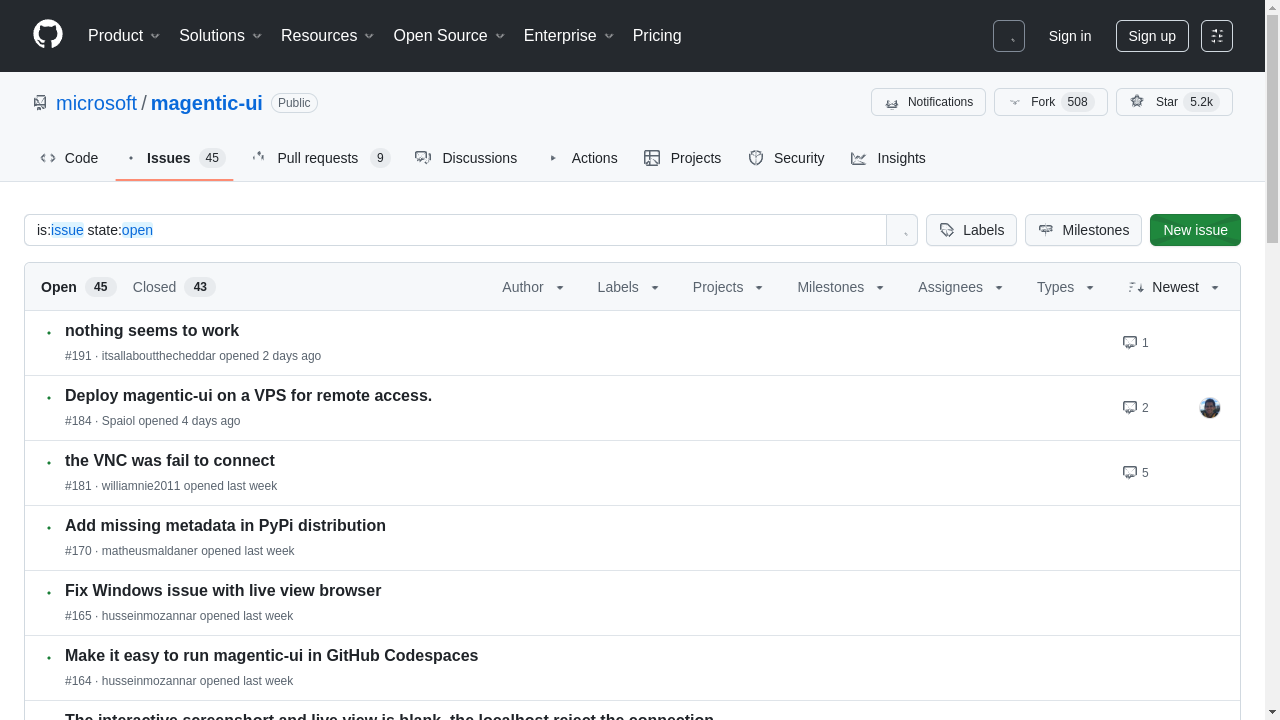

Action decision 1: {'action': 'click', 'action_args': {'id': '45'}}
Action feedback 1: Clicked 45


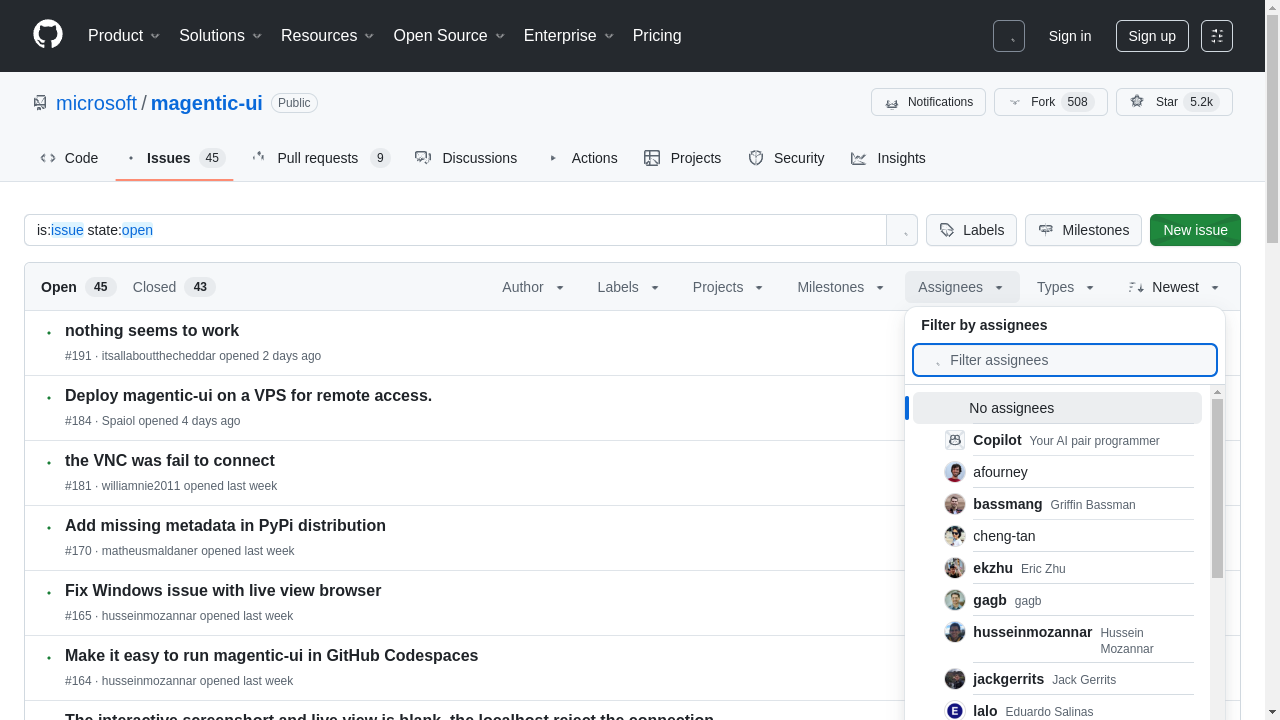

Action decision 2: {'action': 'click', 'action_args': {'id': '138'}}
Action feedback 2: Clicked 138


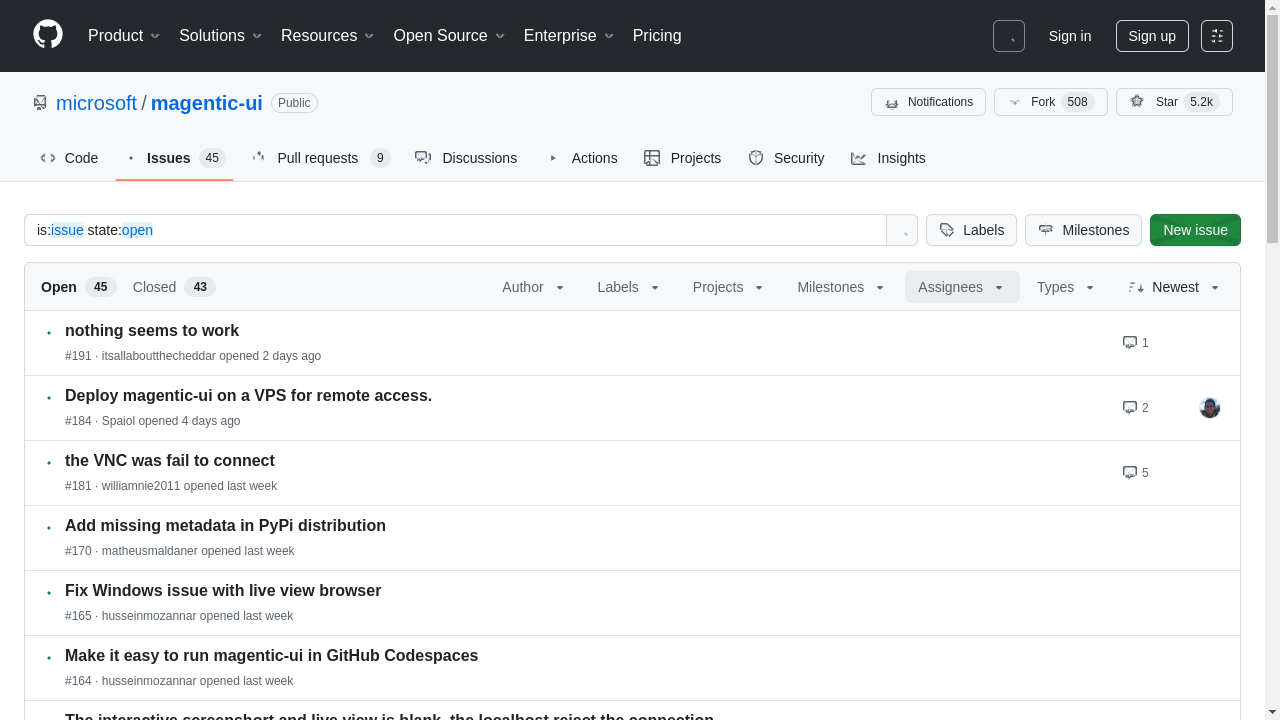

Future exception was never retrieved
future: <Future finished exception=TargetClosedError('Target page, context or browser has been closed')>
playwright._impl._errors.TargetClosedError: Target page, context or browser has been closed
Future exception was never retrieved
future: <Future finished exception=Exception('Connection closed while reading from the driver')>
Exception: Connection closed while reading from the driver
Future exception was never retrieved
future: <Future finished exception=TargetClosedError('Target page, context or browser has been closed')>
playwright._impl._errors.TargetClosedError: Target page, context or browser has been closed
Future exception was never retrieved
future: <Future finished exception=Exception('Connection closed while reading from the driver')>
Exception: Connection closed while reading from the driver
Future exception was never retrieved
future: <Future finished exception=Exception('Connection closed while reading from the driver')>
Exception: C

Action decision 3: {'action': 'click', 'action_args': {'id': '138'}}
Action feedback 3: Clicked 138


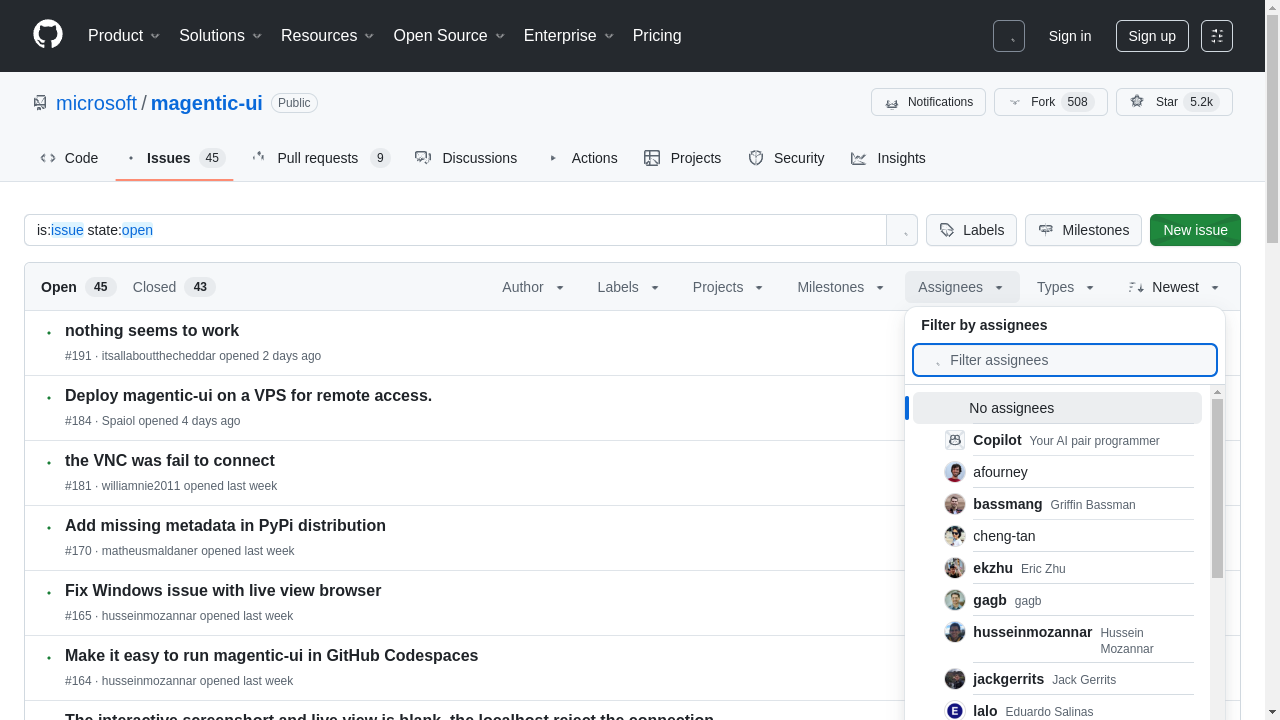

Action decision 4: {'action': 'click', 'action_args': {'id': '169'}}
Action feedback 4: Clicked 169


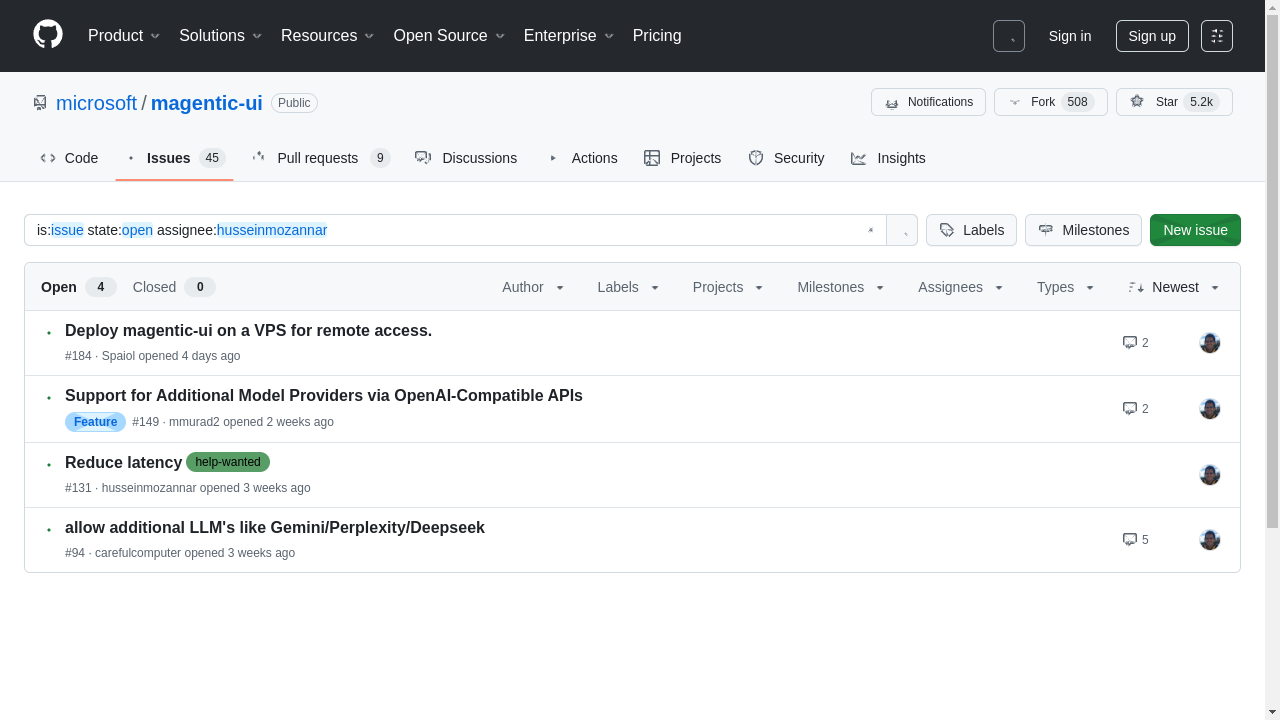

Action decision 5: {'action': 'stop_action', 'action_args': {'final_answer': "The open issues assigned to husseinmozannar on the microsoft/magentic-ui repo are:\n1. Deploy magentic-ui on a VPS for remote access.\n2. Support for Additional Model Providers via OpenAI-Compatible APIs\n3. Reduce latency\n4. Allow additional LLM's like Gemini/Perplexity/Deepseek"}}
Action feedback 5: The open issues assigned to husseinmozannar on the microsoft/magentic-ui repo are:
1. Deploy magentic-ui on a VPS for remote access.
2. Support for Additional Model Providers via OpenAI-Compatible APIs
3. Reduce latency
4. Allow additional LLM's like Gemini/Perplexity/Deepseek


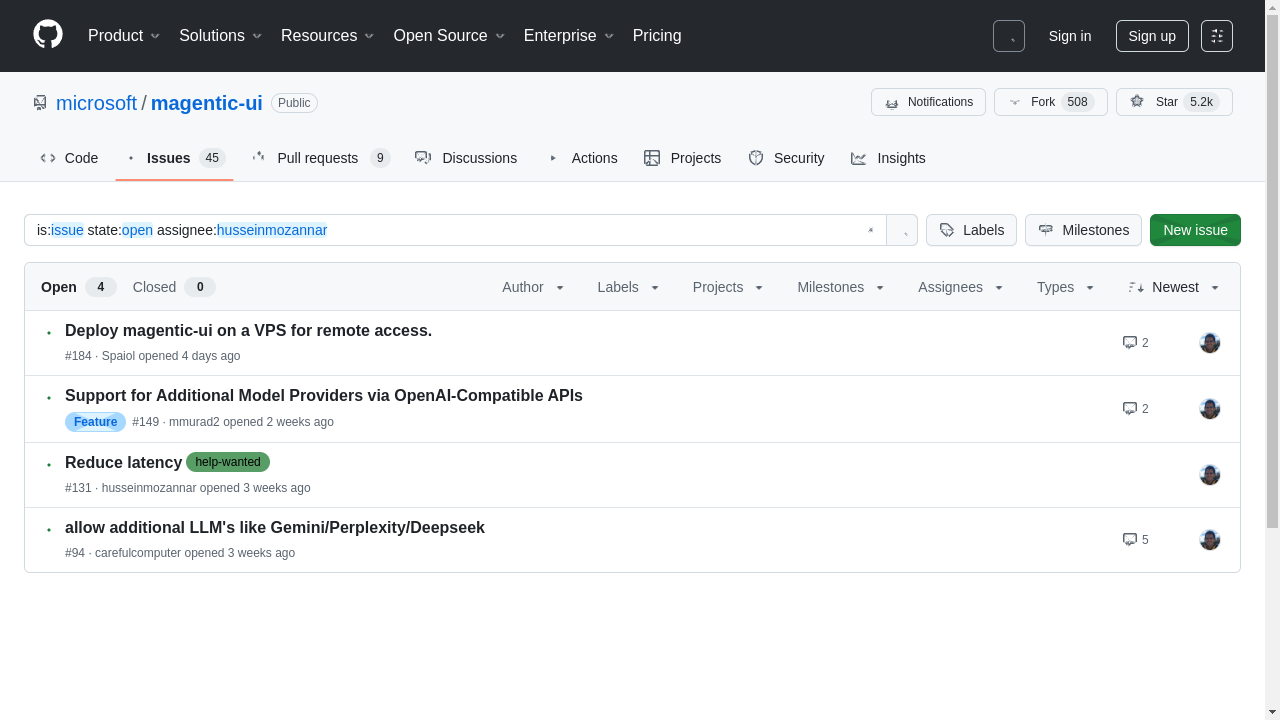

The open issues assigned to husseinmozannar on the microsoft/magentic-ui repo are:
1. Deploy magentic-ui on a VPS for remote access.
2. Support for Additional Model Providers via OpenAI-Compatible APIs
3. Reduce latency
4. Allow additional LLM's like Gemini/Perplexity/Deepseek


In [72]:
from openai import OpenAI
import os
openai_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
agent = BrowserUseAgent(openai_client)
try:
    final_answer = await agent.execute_task("find the open issues assigned to husseinmozannar on the microsoft/magentic-ui repo on github")
    print(final_answer)
finally:
    await agent.close()

Success! Our agent again performed the task correctly!

With this tutorial, I hope to have convinced you that `magentic-ui` can help you build a browser-use agent more easily. You might be curious how to build the best browser-use agent possible given this, and we have already implemented one for you with many features that we haven't discussed previously in Magentic-UI which we will discuss next. See tutorial Level 3 for this.